### Imports

In [39]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from utils.utility_functions import listdir_nohidden_sorted as lsdir
from vision.vision_utils.video_seq_generator import VideoSeqGenerator

### Paths

In [41]:
MED_FALL = "/home/jovyan/work/MED_Fall"
GROUND_TRUTH_PATH = f"{MED_FALL}/vision/vision_dataset/ground_truth_new"
FRAMES_PATH = f"{MED_FALL}/vision/vision_dataset/extracted_frames"

### Utility Functions

In [42]:
def get_cam(name: str) -> int:
    """
    Extract cam number from each video frame name
    ------

    arguments:
        - name: string containing the frame name. Examle: 'Actor_1_bed_cam_1_0000'

    outputs:
        - cam_number: integer containg the cam number of the provided frame name.
                    Example: if name is 'Actor_1_bed_cam_1_0000', cam_number is: 1.
    """

    start = name.find("cam_")
    ind = start + 4
    cam_number = name[ind]
    return int(cam_number)


def show_frames_series(
    frames_series: np.array, title: str, figsize: tuple[int, int] = (20, 20)
):
    """
    plot a series of SEQ_LEN frames with respective labels as titles.
    --------

    arguments:
        - frames_series: np.array containg SEQ_LEN images.
        - title: strcontainging the label of the series of frame. The label is calculated as the mode (most frequent label) of the single frames' labels.
        - fig_size: Optional. Tuple of two integers containing the figure dimensions for the plot. Default is (20, 20).

    """
    rows = 5

    fig = plt.figure(figsize=figsize)
    for n, image in enumerate(frames_series):
        a = fig.add_subplot(rows, int(len(frames_series) / float(rows)), n + 1)

        plt.imshow(image)
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

### Hyperparameters

In [43]:
SEQ_LEN: int = 20
BATCH_SIZE: int = 32
INPUT_SHAPE: tuple[int, int, int] = (112, 112, 3)

## Load Dataset

In [44]:
# Load all csv files (one per actor). Each file contains frames names and respective labels.
dfs = []
for file in lsdir(GROUND_TRUTH_PATH):
    df = pd.read_csv(file)
    dfs.append(df)
# concatenate all csv files in one pandas DF
dataset = pd.concat(dfs, ignore_index=True, axis=0)
dataset = dataset.iloc[:, 2:]
dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004
...,...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615
1182296,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616
1182297,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617
1182298,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618


In [45]:
# Select only "on_air" frames (where actors are performing sequences)
dataset_onair = dataset.loc[dataset["ar_labels"] == "on_air"].copy()
dataset_onair

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
1182213,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4533
1182214,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4534
1182215,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4535
1182216,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4536


In [46]:
# check on_air dataset samples per class
dataset_onair["macro_labels"].value_counts()

adl           269836
falling        88312
lying_down     27958
Name: macro_labels, dtype: int64

In [47]:
# instantiate and fit a OneHotEncoder for the macro classes (adl, fall, lie_down)
le = LabelBinarizer()
le.fit(dataset_onair["macro_labels"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'adl': array([1, 0, 0]),
 'falling': array([0, 1, 0]),
 'lying_down': array([0, 0, 1])}

## Balance dataset

In [48]:
dataset_balanced = dataset_onair.copy()  # make a copy of on_air dataset

counts = dataset_balanced["macro_labels"].value_counts()  # count samples per class
minority_class_samples = counts[-1]  # store minority class samples

# select adl samples
adl_samples = dataset_onair.loc[dataset["macro_labels"] == "adl"]

# select fall samples
fall_samples = dataset_onair.loc[dataset["macro_labels"] == "falling"]

## subsample

# count exceeding adl samples wrt minority_class_samples
adl_todrop_ind = len(adl_samples) - minority_class_samples
# count exceeding fall samples wrt minority_class_samples
fall_todrop_ind = len(fall_samples) - minority_class_samples

# select indices to drop from adl subset
adl_samples_to_drop = adl_samples.iloc[-adl_todrop_ind:]

# select indices to drop from fall subset
fall_samples_to_drop = fall_samples.iloc[-fall_todrop_ind:]

# actually drop exceeding adl samples
dataset_balanced.drop(adl_samples_to_drop.index, axis=0, inplace=True)

# actually drop exceeding fall samples
dataset_balanced.drop(fall_samples_to_drop.index, axis=0, inplace=True)

# count samples per class of the balanced dataset
dataset_balanced["macro_labels"].value_counts()

adl           27958
falling       27958
lying_down    27958
Name: macro_labels, dtype: int64

## Train test split

In [49]:
# Take first 90% of the balanced dataset as train data and remaining 10% as val data.
# NB: no shuffling is applied as frames must be consecutive to later split them in time-series.
split_ratio = 0.7
split = int(len(dataset_balanced) * split_ratio)
train_set = dataset_balanced.iloc[:split, :].copy()
val_set = dataset_balanced.iloc[split:, :].copy()

In [50]:
# show train set
train_set

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
274431,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1971
274432,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1972
274433,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1973
274434,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1974


In [51]:
# show val set
val_set

,micro_labels,macro_labels,ar_labels,frame_name
274436,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1976
274437,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1977
274438,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1978
274439,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1979
274440,lie_down_on_the_floor,lying_down,on_air,actor_1_walk_cam_2_1980
...,...,...,...,...
1179952,lie_down_on_the_floor,lying_down,on_air,actor_4_chair_full_ph_cam_7_2272
1179953,lie_down_on_the_floor,lying_down,on_air,actor_4_chair_full_ph_cam_7_2273
1179954,lie_down_on_the_floor,lying_down,on_air,actor_4_chair_full_ph_cam_7_2274
1179955,lie_down_on_the_floor,lying_down,on_air,actor_4_chair_full_ph_cam_7_2275


In [52]:
# show samples per class in each set
print(train_set["macro_labels"].value_counts())
print(val_set["macro_labels"].value_counts())

adl           27958
falling       20358
lying_down    10395
Name: macro_labels, dtype: int64
lying_down    17563
falling        7600
Name: macro_labels, dtype: int64


## Instantiate train and val generators
### VideoSeqGenerator works as follows:
- takes a dataframe containing the frame names and the corresponding labels as input
- splits the dataframe in time series of length SEQ_LEN
- for each series: 
    - loads a batch made of BATCH_SIZE * SEQ_LEN frames into a tensor called "X"
    - for each window (time-series) of the batch caluculates the mode of the frames, applies OneHotEncoding and stores the encoded windows' labels in a tensor called "y".
    - returns X,y. 
      X has shape (BATCH_SIZE, SEQ_LEN, IMAGE_SIZE), for example (32, 20, 224, 224, 3)
      y has shape (BATCH_SIZE, 3),  where 3 derives from the one hot encoding of the 3 classes (adl, fall, lie_down)

In [53]:
# instantiating train generator. For this test there will be only one generator which takes the whole dataset as input
train_gen = VideoSeqGenerator(
    frames_path=FRAMES_PATH,
    df=dataset_balanced,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    label_encoder=le,
    input_shape=INPUT_SHAPE,
)

In [54]:
val_gen = VideoSeqGenerator(
    frames_path=FRAMES_PATH,
    df=val_set,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    label_encoder=le,
    input_shape=INPUT_SHAPE,
)

### Plot a frames series from first batch
    The first two images are black, in fact they are padding frames, because those two frames in the dataframe were part of another sequence. In other words, such frames had a different camera number with respect to the others.

batch_X.shape: (32, 20, 112, 112, 3) batch_y.shape: (32, 3)


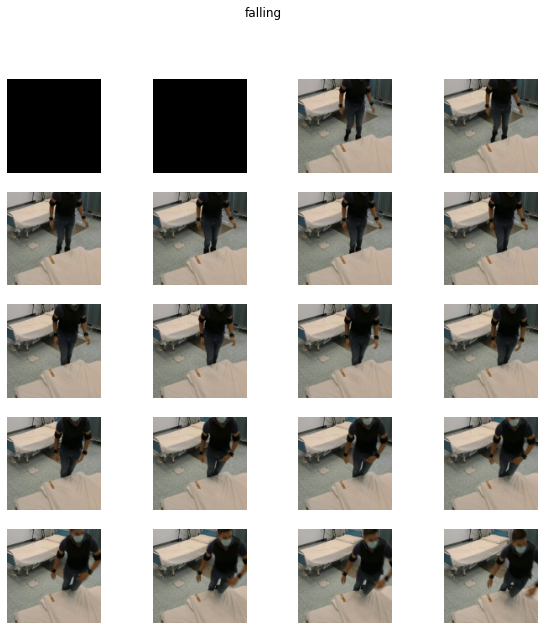

In [55]:
# get first batch from train generator
batch_X, batch_y = train_gen.__getitem__(101)
print("batch_X.shape:", batch_X.shape, "batch_y.shape:", batch_y.shape)

b = 3
frames = batch_X[b]
title = np.expand_dims(batch_y[b], axis=0)
title = le.inverse_transform(title)[0]
title

show_frames_series(frames, title, figsize=(10, 10))

### Metrics

In [56]:
# we keep track of the recall (sensitivity, or number of correctly predicted true positive).
# This metric is especially important for the fall class, where we want to have maximum recall to be sure we don't miss any fall event.
metrics = [
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Recall(class_id=0, name="adl"),
    tf.keras.metrics.Recall(class_id=1, name="fall"),
    tf.keras.metrics.Recall(class_id=2, name="lying_down"),
]

## Define 3D CNN Model
Architecture taken from:
Tran, D., Bourdev, L., Fergus, R., Torresani, L., & Paluri, M. (2015). Learning spatiotemporal features with 3d convolutional networks. In Proceedings of the IEEE international conference on computer vision (pp. 4489-4497).

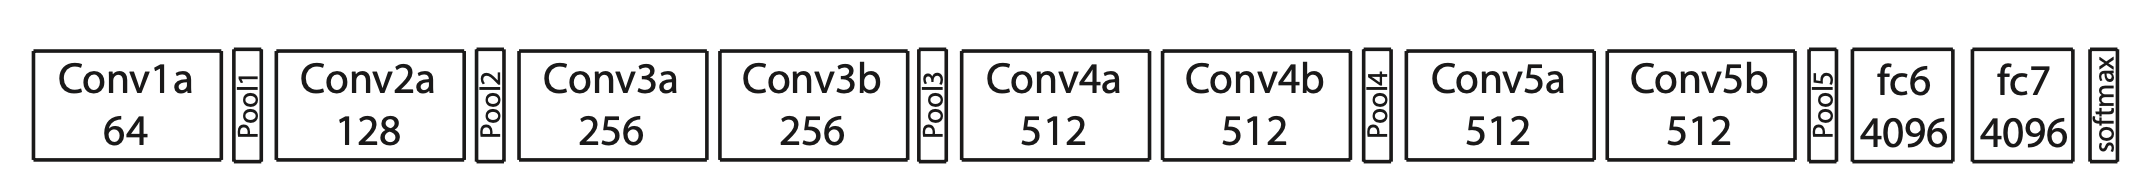

## Added ConvLSTM2D layers to the 3D CNN architecture

In [58]:
model = Sequential()
model.add(layers.Input(shape=(SEQ_LEN,) + INPUT_SHAPE))
model.add(layers.Rescaling(scale=1.0 / 255))
model.add(layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((1, 2, 2), strides=(1, 1, 1), padding="same"))
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(128, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(256, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.Conv3D(256, (2, 2, 2), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(512, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.Conv3D(512, (2, 2, 2), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(512, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.Conv3D(512, (2, 2, 2), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.Dropout(0.3))

model.add(layers.ConvLSTM2D(256, (3, 3), return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.ConvLSTM2D(128, (3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(3, "softmax"))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 20, 112, 112, 3)   0         
_________________________________________________________________
conv3d_128 (Conv3D)          (None, 20, 112, 112, 64)  5248      
_________________________________________________________________
max_pooling3d_79 (MaxPooling (None, 20, 112, 112, 64)  0         
_________________________________________________________________
conv3d_129 (Conv3D)          (None, 20, 112, 112, 128) 221312    
_________________________________________________________________
max_pooling3d_80 (MaxPooling (None, 10, 56, 56, 128)   0         
_________________________________________________________________
conv3d_130 (Conv3D)          (None, 10, 56, 56, 256)   884992    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 56, 56, 256) 

### Compile Model

In [59]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)

### Fit Model

In [60]:
history = model.fit(train_gen, epochs=20)

2022-08-25 13:12:19.239867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
  1/131 [..............................] - ETA: 18:47:27 - loss: 1.0977 - categorical_accuracy: 0.1562 - adl: 0.0000e+00 - fall: 0.0000e+00 - lying_down: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
print(
    classification_report(
        y_true=train_datagen.classes,
        y_pred=y_preds,
        target_names=list(val_datagen.class_indices.keys()),
    )
)